In [64]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
from io import StringIO
import numpy as np
import statsmodels.api as sm
from scipy.stats import poisson 

In [2]:
with open('../data/api_toxen.json') as fi:
    credentials = json.load(fi)
    
api_key = credentials['api_key']

In [3]:
endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.geojson'

In [4]:
params = {'offense_description':'BURGLARY- AGGRAVATED',  '$where': 'incident_reported between \'2021-01-01\' and \'2021-06-30\'','$limit': 10000}

In [5]:
response = requests.get(endpoint, params)
response

<Response [200]>

In [6]:
BA_gdf = gpd.read_file(StringIO(response.text))
BA_gdf.columns

Index(['victim_county_resident', 'zip_code', 'victim_number', 'offense_nibrs',
       'rpa', 'latitude', 'victim_race', 'incident_number',
       'investigation_status', 'offense_number', 'offense_description',
       'longitude', 'domestic_related', 'victim_ethnicity',
       'incident_location', 'victim_description', 'location_code',
       'report_type', 'incident_reported', 'weapon_description',
       'location_description', 'weapon_primary', 'report_type_description',
       'victim_type', 'incident_status_code', 'incident_status_description',
       'zone', 'victim_gender', 'incident_occurred', 'primary_key',
       'geometry'],
      dtype='object')

# 2

In [7]:
ctract_gdf = gpd.read_file("../data/tl_2019_47_tract.shp")
ctract_gdf = ctract_gdf.to_crs(epsg=4326)
ctract_gdf.rename(columns= {'TRACTCE': 'tract'}, inplace=True)
ctract_gdf

,STATEFP,COUNTYFP,tract,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43916 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56851, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,47,157,022112,47157022112,221.12,Census Tract 221.12,G5020,S,3293232,0,+35.0282414,-090.0009887,"POLYGON ((-90.01257 35.02328, -90.01256 35.023..."
1493,47,073,050501,47073050501,505.01,Census Tract 505.01,G5020,S,83253173,0,+36.5659218,-082.7714427,"POLYGON ((-82.85011 36.54106, -82.84955 36.541..."
1494,47,073,050601,47073050601,506.01,Census Tract 506.01,G5020,S,23852225,177932,+36.5836443,-082.6318663,"POLYGON ((-82.68939 36.58793, -82.68936 36.588..."
1495,47,073,050602,47073050602,506.02,Census Tract 506.02,G5020,S,23381992,668716,+36.5467218,-082.6458382,"POLYGON ((-82.69446 36.54855, -82.69445 36.548..."


In [8]:
BA_gdf = BA_gdf[
                ['victim_number',
                'incident_occurred', 
                'incident_number',
                'geometry']
                                    ]
                 

In [9]:
ctract_gdf = ctract_gdf[
                        ['tract',
                        'geometry']
]

In [10]:
ab_by_censustract = gpd.sjoin(BA_gdf, ctract_gdf, op = 'within')
ab_by_censustract

,victim_number,incident_occurred,incident_number,geometry,index_right,tract
0,1,2021-05-04T23:45:00,20210249540,POINT (-86.77000 36.15000),652,016000
4,2,2021-05-04T23:45:00,20210249540,POINT (-86.77000 36.15000),652,016000
63,1,2021-04-02T09:30:00,20210187070,POINT (-86.76000 36.14000),652,016000
129,1,2021-01-04T10:45:00,20210006869,POINT (-86.76000 36.14000),652,016000
158,1,2021-04-20T20:00:00,20210223220,POINT (-86.77000 36.15000),652,016000
...,...,...,...,...,...,...
906,1,2021-06-24T14:00:00,20210344666,POINT (-86.60200 36.19800),567,015405
925,2,2021-02-10T00:01:00,20210083306,POINT (-86.75800 36.05100),1067,018801
1032,1,2021-02-10T00:01:00,20210083306,POINT (-86.75800 36.05100),1067,018801
978,2,2021-04-22T09:45:00,20210225465,POINT (-86.82200 36.16800),98,013602


In [11]:
ab_by_censustract_drop = ab_by_censustract.drop_duplicates(subset=['incident_number'])
ab_by_censustract_drop.groupby('tract').count().nlargest(2,'victim_number')
                                                            

,victim_number,incident_occurred,incident_number,geometry,index_right
tract,,,,,
016300,53,53,53,53,53
016200,21,21,21,21,21


Census Tract 163 had the highest number of aggrevated burglaries at 53.

In [12]:
ab_by_censustract

,victim_number,incident_occurred,incident_number,geometry,index_right,tract
0,1,2021-05-04T23:45:00,20210249540,POINT (-86.77000 36.15000),652,016000
4,2,2021-05-04T23:45:00,20210249540,POINT (-86.77000 36.15000),652,016000
63,1,2021-04-02T09:30:00,20210187070,POINT (-86.76000 36.14000),652,016000
129,1,2021-01-04T10:45:00,20210006869,POINT (-86.76000 36.14000),652,016000
158,1,2021-04-20T20:00:00,20210223220,POINT (-86.77000 36.15000),652,016000
...,...,...,...,...,...,...
906,1,2021-06-24T14:00:00,20210344666,POINT (-86.60200 36.19800),567,015405
925,2,2021-02-10T00:01:00,20210083306,POINT (-86.75800 36.05100),1067,018801
1032,1,2021-02-10T00:01:00,20210083306,POINT (-86.75800 36.05100),1067,018801
978,2,2021-04-22T09:45:00,20210225465,POINT (-86.82200 36.16800),98,013602


# 3

In [13]:
with open('../data/api_census_token.json') as fi:
    credentials = json.load(fi)
    
api_key_1 = credentials['api_key']

In [14]:
endpoint_1 = 'https://api.census.gov/data/2019/acs/acs5'

In [15]:
parameters_1 = {'get': 'B01001_001E', 'for': 'tract', 'in': 'state:47 county:037', 'key': api_key_1}

In [16]:
response_1 = requests.get(endpoint_1, parameters_1)
response_1

<Response [200]>

In [17]:
census_df= pd.DataFrame(response_1.json())
census_df.columns = census_df.iloc[0]
census_df = census_df.iloc[1:,:]
census_df.rename(columns = {'B01001_001E': 'population'}, inplace=True)

In [18]:
endpoint_2 = 'https://api.census.gov/data/2019/acs/acs5/subject'

In [19]:
parameters_2 = {'get': 'S1901_C01_012E', 'for': 'tract', 'in': 'state:47 county:037', 'key': api_key_1}

In [20]:
response_2 = requests.get(endpoint_2, parameters_2)
response_2

<Response [200]>

In [21]:
census_df_subject = pd.DataFrame(response_2.json())
census_df_subject.columns = census_df_subject.iloc[0]
census_df_subject = census_df_subject.iloc[1:,:]
census_df_subject.rename(columns= {'S1901_C01_012E': 'median_income'}, inplace=True)
census_df_subject

,median_income,state,county,tract
1,75579,47,037,015631
2,45129,47,037,015804
3,134786,47,037,017701
4,107813,47,037,017702
5,87591,47,037,018301
...,...,...,...,...
157,37656,47,037,015613
158,54149,47,037,015620
159,48221,47,037,016100
160,50857,47,037,011400


In [22]:
complete_census_df = pd.merge(census_df, census_df_subject, how='inner', on=['state', 'county', 'tract'])
complete_census_df = complete_census_df[['population', 'tract', 'median_income']]
complete_census_df.shape

(161, 3)

In [23]:
ultimate_df = ab_by_censustract.merge(complete_census_df, on="tract")
ultimate_df['population'] = pd.to_numeric(ultimate_df['population'],errors = 'coerce')
ultimate_df.sort_values('median_income').head(50)

,victim_number,incident_occurred,incident_number,geometry,index_right,tract,population,median_income
64,1,2021-05-27T12:00:00,20210293111,POINT (-86.70000 36.14000),912,980100,0,-666666666
62,3,2021-04-19T20:26:00,20210219986,POINT (-86.70000 36.14000),912,980100,0,-666666666
61,2,2021-04-19T20:26:00,20210219986,POINT (-86.70000 36.14000),912,980100,0,-666666666
60,1,2021-04-12T07:00:00,20210247565,POINT (-86.70000 36.14000),912,980100,0,-666666666
63,1,2021-04-19T20:26:00,20210219986,POINT (-86.70000 36.14000),912,980100,0,-666666666
1042,2,2021-04-22T09:45:00,20210225465,POINT (-86.82200 36.16800),98,013602,1818,-666666666
1041,1,2021-02-10T00:01:00,20210083306,POINT (-86.75800 36.05100),1067,018801,5889,101027
1040,2,2021-02-10T00:01:00,20210083306,POINT (-86.75800 36.05100),1067,018801,5889,101027
483,2,2021-03-04T10:30:00,20210129218,POINT (-86.99000 36.07000),569,018407,5001,105917
482,1,2021-01-13T12:52:00,20210024216,POINT (-86.95000 36.06000),569,018407,5001,105917


# 4

In [24]:
ultimate_df = ultimate_df.drop_duplicates(subset=['incident_number'])
ultimate_df_count = ultimate_df['tract'].value_counts().reset_index()
ultimate_df_count.rename(columns = {"index": 'tract', 'tract': 'tot_agg_burg'}, inplace=True)
ultimate_df_2 = ultimate_df.merge(ultimate_df_count, on='tract')
ultimate_df_2.drop(columns = 'victim_number', inplace=True)
ultimate_df_2.drop_duplicates(['population', 'median_income'], inplace=True)
ultimate_df_2['tot_agg_burg'].astype(float)
ultimate_df_2['burglaries_per_1000'] = (ultimate_df_2['tot_agg_burg'] / (ultimate_df_2['population'] / 1000))
ultimate_df_3 = ultimate_df_2.drop(columns=[ 'incident_occurred', 'incident_number', 'index_right'])
ultimate_df_3 = ultimate_df_3.fillna(0)
ultimate_df_3 = ultimate_df_3[ultimate_df_3['population'] != 0]
ultimate_df_3.sort_values('burglaries_per_1000')

,geometry,tract,population,median_income,tot_agg_burg,burglaries_per_1000
447,POINT (-86.92000 36.09000),018202,7222,57500,1,0.138466
819,POINT (-86.75800 36.05100),018801,5889,101027,1,0.169808
792,POINT (-86.78300 36.10700),017800,5498,85189,1,0.181884
793,POINT (-86.71000 36.29000),010303,5105,53143,1,0.195886
817,POINT (-86.60300 36.08200),015619,5105,74335,1,0.195886
...,...,...,...,...,...,...
50,POINT (-86.76000 36.17000),019300,3428,14277,19,5.542590
491,POINT (-86.76000 36.12000),017200,1427,53148,9,6.306938
13,POINT (-86.78000 36.14000),016200,3074,27174,21,6.831490
0,POINT (-86.77000 36.15000),016000,945,37083,7,7.407407


TypeError: __init__() got an unexpected keyword argument 'title'

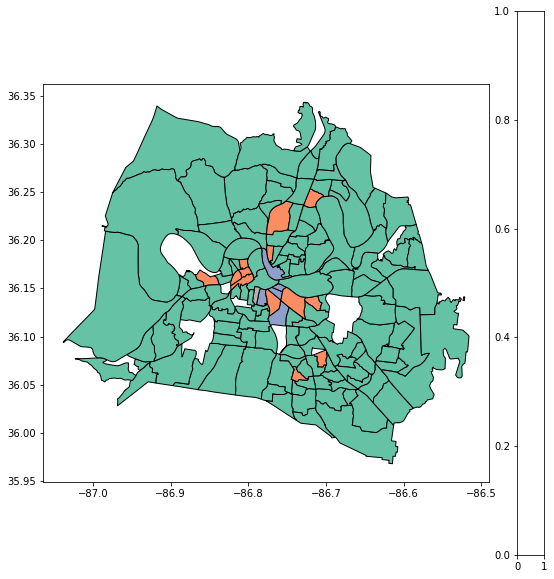

In [25]:
chloropleth = gpd.sjoin(ctract_gdf, ultimate_df_3, how = 'left')
chloropleth = chloropleth.drop(columns = ['tract_right', 'index_right'])
chloropleth.rename(columns = {'tract_left': 'tract'}, inplace=True)
chloropleth = chloropleth.dropna()
leg_kwds = {'title': 'burglaries_per_1000', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 2}

chloropleth.plot(column = 'burglaries_per_1000', figsize=(10, 10),
                 edgecolor = 'black',
                 legend = True, legend_kwds = leg_kwds, 
                 cmap = 'Set2')
plt.show()

In [ ]:
chloropleth['burglaries_per_1000'].unique()

# 5

In [78]:
ultimate_df_3.median_income = ultimate_df_3.median_income.astype('int64')

In [79]:
ultimate_df_3.sort_values('median_income', ascending=True).reset_index()
ultimate_df_3 = ultimate_df_3.iloc[1:, :]

In [104]:
modeling_tract_gdf = ultimate_df_3

In [124]:
base_model = (sm.GLM(endog = ultimate_df_3['tot_agg_burg'],
                             exog =  sm.add_constant(modeling_tract_gdf[[]]),
                             family = sm.families.Poisson(),
                             offset = np.log((ultimate_df_3['population'] / 1000)) )
                     .fit()
                     )

In [125]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           tot_agg_burg   No. Observations:                  145
Model:                            GLM   Df Residuals:                      144
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -557.74
Date:                Sat, 09 Oct 2021   Deviance:                       635.76
Time:                        12:47:34   Pearson chi2:                 1.30e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2366      0.035      6.768      0.000       0.168       0.305
==============================================================================
"""

In [126]:
burg_discrete_range = np.arange(1,52)

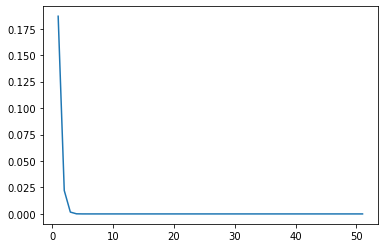

In [128]:
poisson_dist = poisson.pmf(burg_discrete_range,
                mu = (base_model.params[0])
                 )
plt.plot(burg_discrete_range, poisson_dist);

In [ ]:
poisson_dist

In [99]:
poisreg_base = pmf

SyntaxError: invalid syntax (Temp/ipykernel_22368/2922110406.py, line 2)

5.2 

In [93]:
poisreg_population = (sm.GLM(endog = ultimate_df_3['tot_agg_burg'],
                             exog =  sm.add_constant(ultimate_df_3['median_income']),
                             family = sm.families.Poisson(),
                             offset = np.log(ultimate_df_3['population']) )
                     .fit()
                     )

In [94]:
poisreg_population.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           tot_agg_burg   No. Observations:                  145
Model:                            GLM   Df Residuals:                      143
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -493.59
Date:                Sat, 09 Oct 2021   Deviance:                       507.46
Time:                        11:25:05   Pearson chi2:                 1.00e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5872
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.6093      0.101    -55.702      0.000      -5.807      -5.412
median_income -1.795e-05   1.72e-06    -10.413      0.000   -2.13e-05   -1.46e-05
=================================================================================
"""

In [95]:
poisreg_population.params[0]
#range from lowest to highest median income values.  Num 50, tells linspace to seperate 50 points equidistant and draw a line.
income_range = np.linspace(14277, 190375, num= 50)

In [96]:
poisson_line = np.exp(poisreg_population.params[0]+poisreg_population.params[1]*income_range)

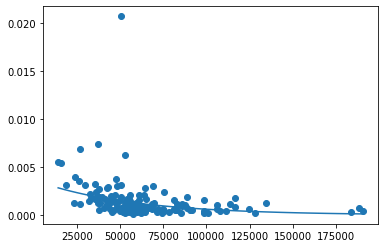

In [97]:
plt.scatter(x= ultimate_df_3['median_income'],
            y= (ultimate_df_3['tot_agg_burg']/ultimate_df_3['population']));
plt.plot(income_range, poisson_line)